In [149]:
mystock = 'icui'

In [150]:
# Load Data and set options
import stockdatalib as sd
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
# files: screener_results.csv, constituents_csv.csv
stock_count, stock_fields, sp_df = sd.init_stocks_data('./data/','custom_stocklist.csv')
#sp_df

In [151]:
# Print Basic Info
sd.set_stock(mystock)
stock_info = sd.get_stock_info(mystock)
# Get stock company information
company_name = stock_info['name'][0]
company_sector = stock_info['sector'][0]
print('Symbol:'+mystock.upper(), ',Company:'+company_name,',Sector:'+company_sector)
squote = sd.quote(mystock)
if not squote.empty:
    print('Closed $'+str(squote.close[0]),'on',squote.date[0])

Symbol:ICUI ,Company:ICU Medical Inc ,Sector:Health Care
Closed $198.1 on 2020-05-08 13:30:00


In [152]:
# Stats
sd.key_stat(mystock)

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,icui,2020-03-31,20780000.0,328607000.0,20381000.0,270.717702,0.81,16834000.0,0.042774,121415000.0,0.582194


In [153]:
# Get stock data and Set range
price_df = sd.GetStockDataFrame(mystock)
price_df = sd.DatesRange(price_df, '2019-08-01') # limit the data since a specific past date or a range

In [154]:
# Print range table
rc = ''
if not squote.empty:
    print('Closed $'+str(squote.close[0]),'on',squote.date[0])

if not price_df.empty:
    rc, price_df2, low_df, hi_df, action_df = sd.GetBuySellEnvelope(mystock,price_df, 5)
    if not rc:
        print("Function Failed")
    
action_df

Closed $198.1 on 2020-05-08 13:30:00


,Signal,Recommendation,Statement,Last Date,Average % Change,Signal Price,Range
0,Buy,buy,Buy@198.1 - Sell@217.36,2020-05-08 13:30:00,-5.67,198.10,198.1 - 217.36
1,Sell,no,,2020-05-07 13:30:00,5.47,217.36,


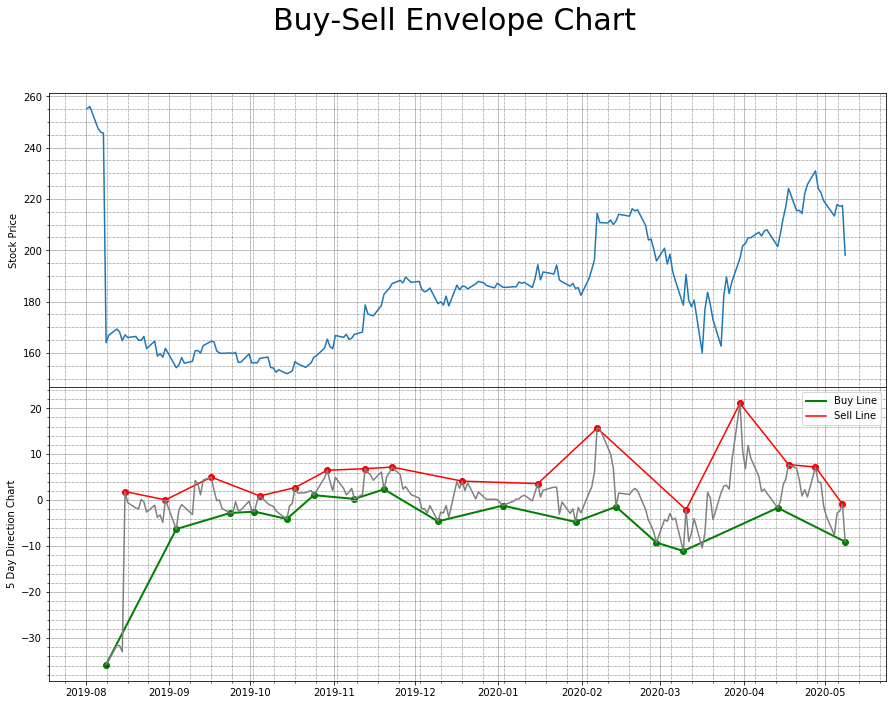

Closed $198.1 on 2020-05-08 13:30:00
Price change range is from  -5.67% to 5.47%
Buy range from  198.1 to 208.94
Last Buy signal on  2020-05-08 13:30:00 Close price was $ 198.1
Last Sell signal on  2020-05-07 13:30:00 Close price was $ 217.36


In [155]:
# Sell-Buy Range
if(not price_df.empty):
    price_df3, low_df, hi_df = sd.PlotBuySellEnvelope(price_df, 5)

    print('Closed $'+str(squote.close[0]),'on',squote.date[0])
    low_df.dropna(inplace=True)
    hi_df.dropna(inplace=True)

    date_last_buy = low_df.index[-1]
    date_last_sell = hi_df.index[-1]

    price_last_buy = price_df3[price_df3.index == low_df.index[-1]][0]
    price_last_sell = price_df3[price_df3.index == hi_df.index[-1]][0]
 
    ave_min_delta = low_df.mean()
    ave_max_delta = hi_df.mean()
    print("Price change range is from ",str(round(ave_min_delta,2))+"% to", str(round(ave_max_delta,2))+"%")

    if date_last_buy > date_last_sell:
        print("Buy range from ",round( price_last_buy,2), "to", 
              round( price_last_buy + (price_last_buy * ave_max_delta / 100), 2))
    else:
        print("Sell range from ",round( price_last_sell,2), "to", 
              round(price_last_sell + (price_last_sell * ave_min_delta / 100) ,2))

    print("Last Buy signal on ",date_last_buy,"Close price was $",round(price_last_buy,2))
    print("Last Sell signal on ",date_last_sell,"Close price was $",round(price_last_sell,2))

<Figure size 1080x432 with 0 Axes>

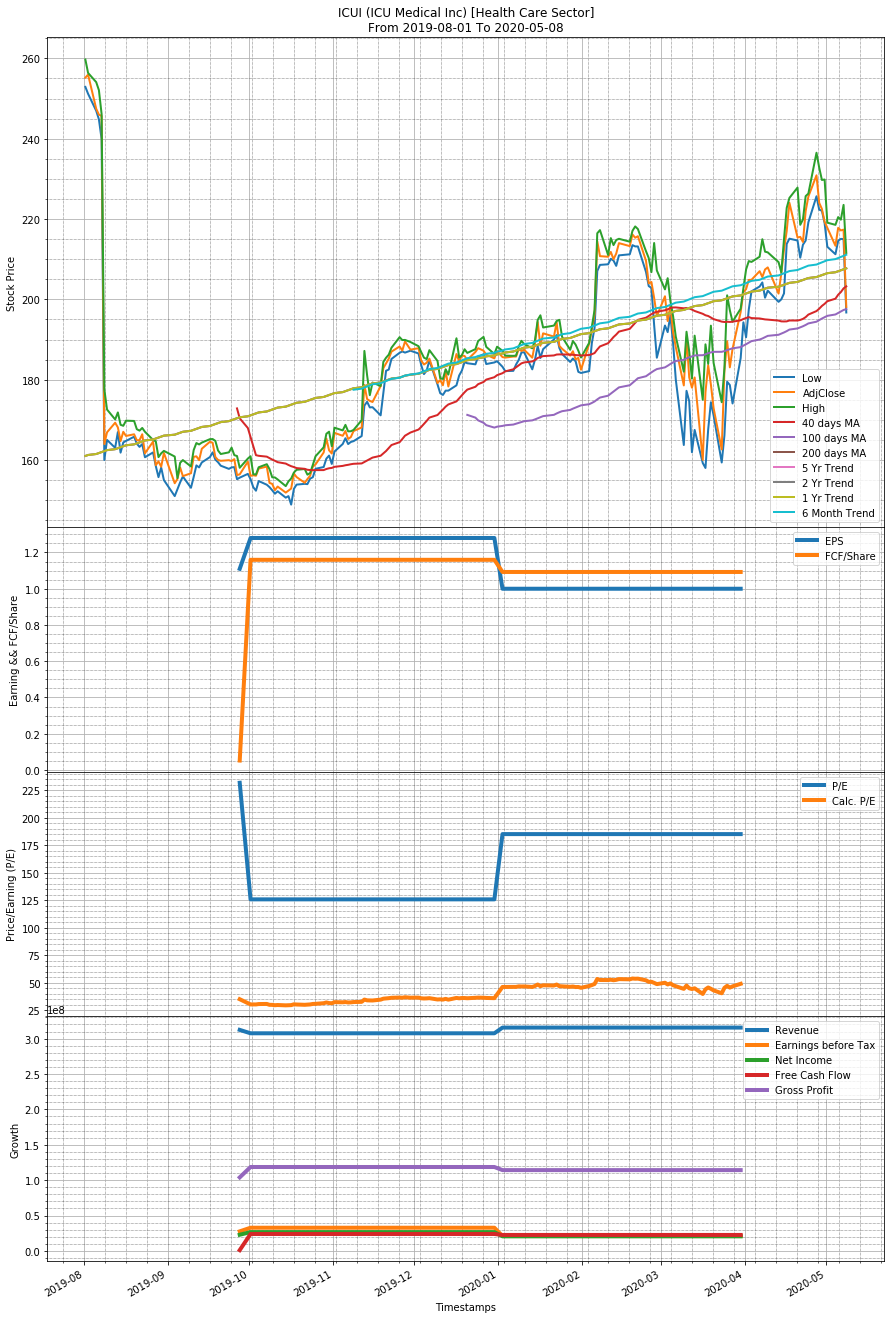

In [156]:
# Plot stock basic charts
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_df = sd.DatesRange(price_df, '2019-08-01') # limit the data since a specific past date or a range

    linear_trends = sd.PlotBasicCharts(mystock,price_df)

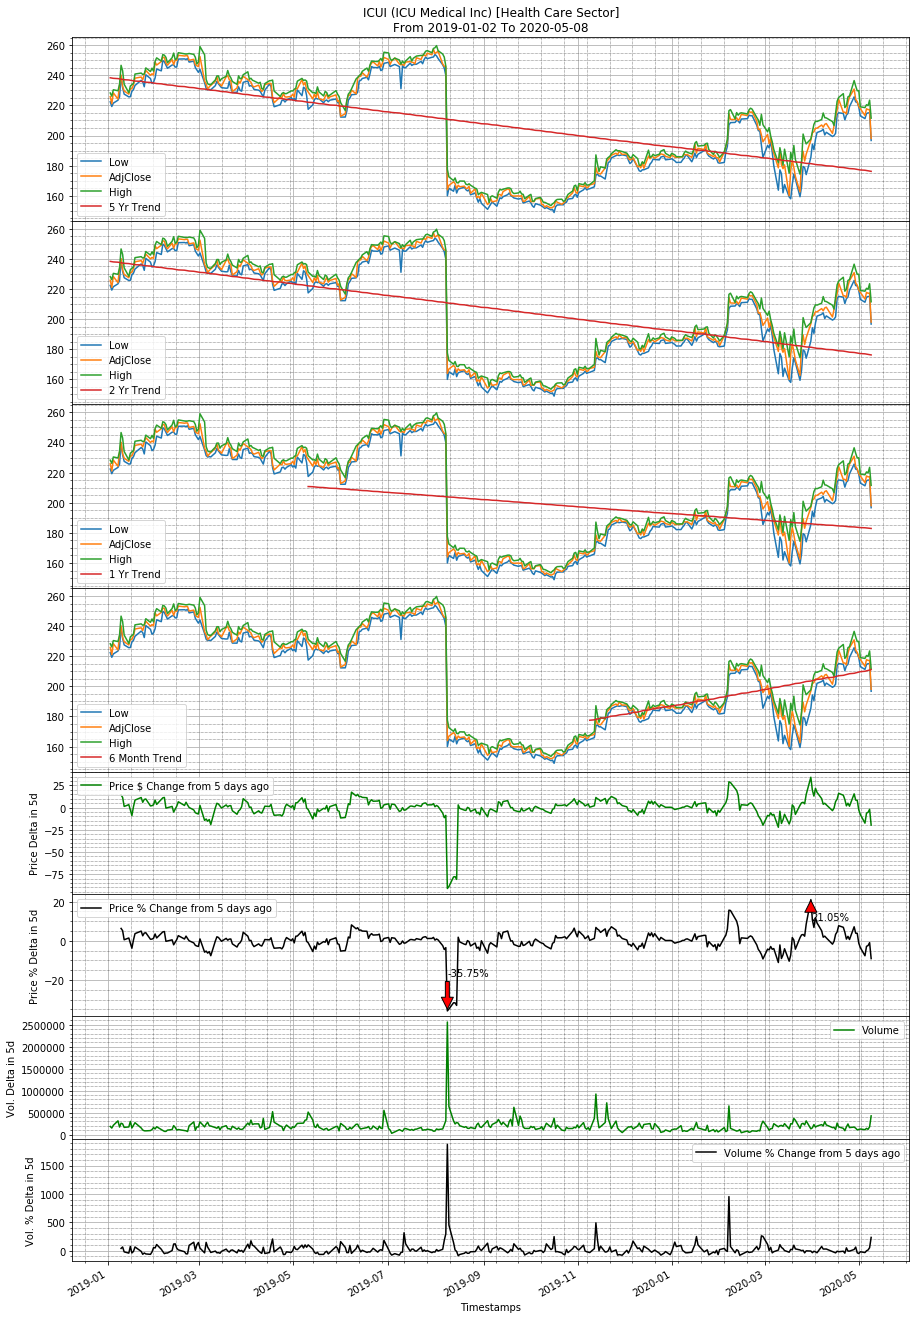

In [157]:
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_df = sd.DatesRange(price_df, '2019-01-01')
    price_data_df, maximums_table_df, trends = sd.PlotTrends(mystock,price_df)

In [158]:
if(not price_df.empty):
    for k,v in trends.items():
        print(k,round(v[1],4))

5y Trend -0.1827
2y Trend -0.1827
1y Trend -0.1108
6m Trend 0.2711


In [159]:
if(not price_df.empty):
    maximums_table_df

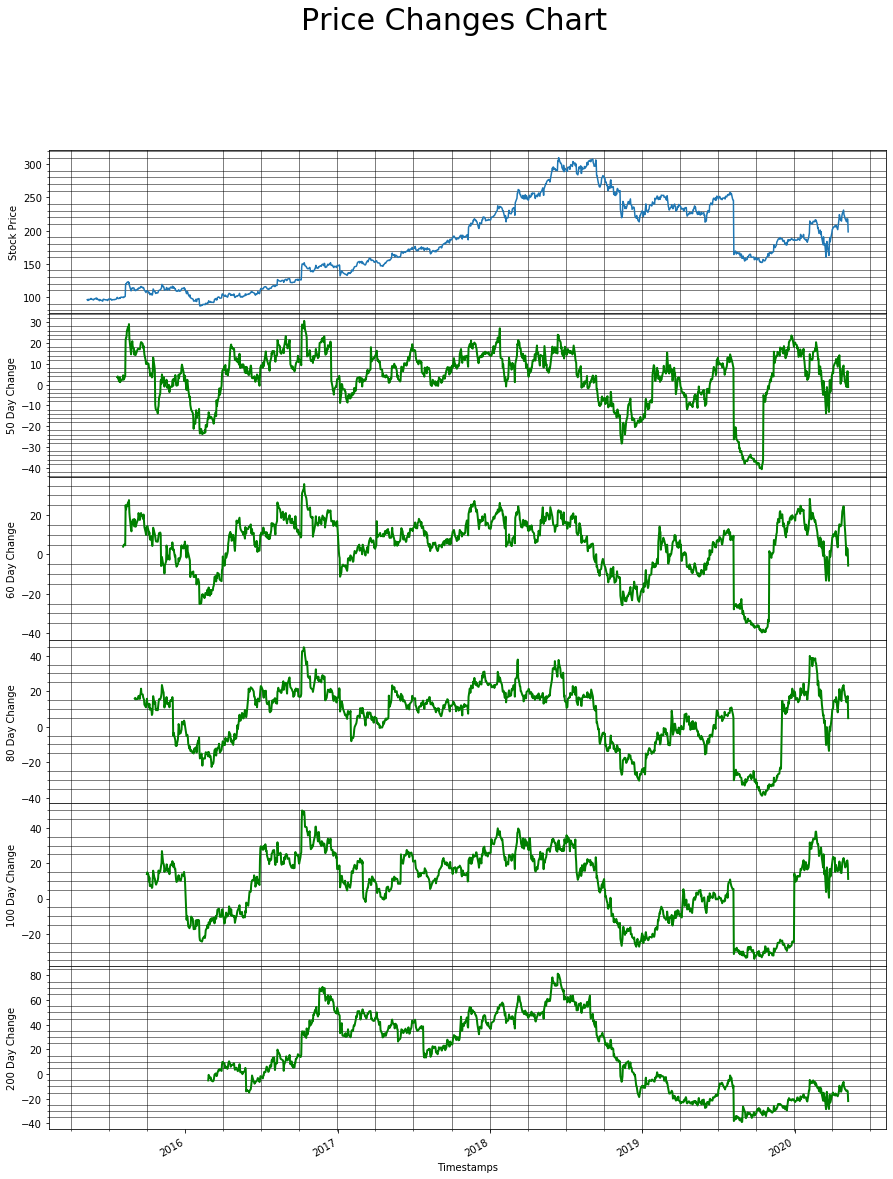

In [160]:
# Set the stock and get the prices dataframe
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    # You can limit the range if needed
    #price_df = sd.DatesRange(price_df, '2016-02-01')
   
    sd.PlotPriceChangesPercent(price_df,[50,60,80,100,200])

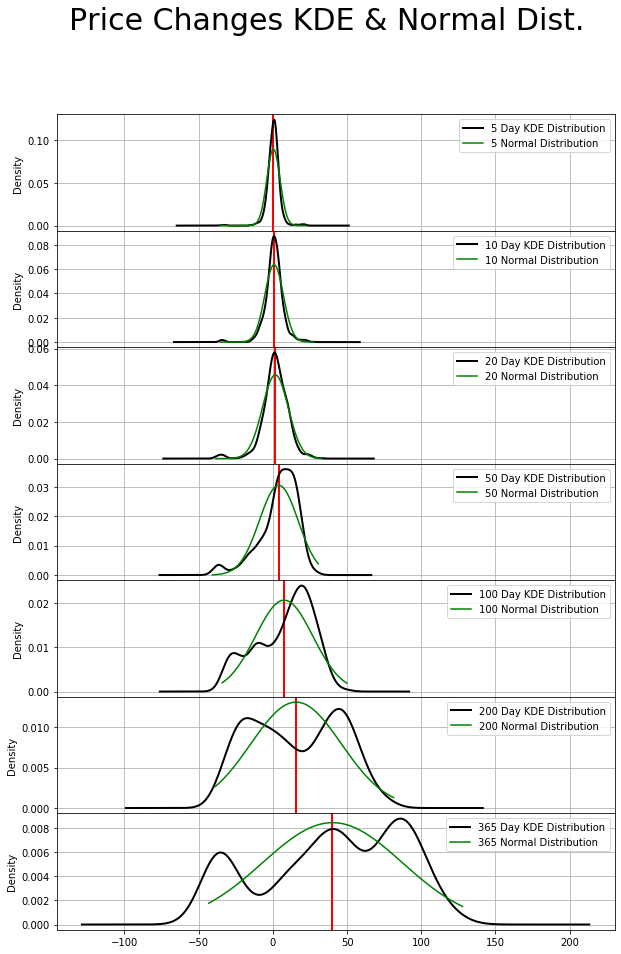

In [161]:
# Set the stock and get the prices dataframe
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_changes, stats = sd.PlotPriceChangesKDE(price_df,[5,10,20,50,100,200,365])
    stats